In [1]:
"""
EATING DISORDERS MONTECATINI

Purpose: HDDMrl analysis of the PRL data as a function of diagnostic category (HC, AN, BN, RI) and stimulus.

(1) diag_cat (diagnostic category) 

- AN     anorexia, 
- BN     bulimia, 
- HC     university students not at risk according to the EAT-26,
- RI     university students at risk according to the EAT-26, recovered bulimics, recovered anorexics.

(2) stim (stimulus)

- food and neutral images,
- two neutral images.

Some participants have been removed so as to avoind problems with the Gelman-Rubin index.
All excluded participants belong to the HC group, apart from al_ro_1989_04_25_160_f, who is AN.
There are 302 participants.

Written by Corrado Caudek (2023-01-26)

"""


import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-01-26 15:18:48


This notebook follows the [tutorial](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#checking-results) on the hddm webpage.


In [2]:
# Import modules

# warning settings
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

# print(pickle.format_version)


/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The hddm version is 0.9.7


In [3]:
# custom save/load fns
def savePatch(self, fname):
    with open(fname, "wb") as f:  # write binary
        pickle.dump(self, f)


hddm.HDDM.savePatch = savePatch


def load1(fname):
    model = pickle.load(open(fname, "rb"))
    return model


hddm.load1 = load1

In [4]:
# custom fns (workaround) to compute posterior predictive checks for HDDM Regressor models
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node):  # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]


def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            # Only modification of original Kabuki code
            sampled_data.reset_index(inplace=True)
            sampled_data = sampled_data.join(data.reset_index(), lsuffix="_sampled")
        datasets.append(sampled_data)
    return datasets


def post_pred_gen(
    model, groupby=None, samples=500, append_data=False, progress_bar=True
):
    results = {}
    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = (
            (name, model.data.ix[obs["node"].value.index])
            for name, obs in model.iter_observeds()
        )
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, "random"):
            continue  # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(
            node, samples=samples, data=data, append_data=append_data
        )
        results[name] = pd.concat(
            datasets, names=["sample"], keys=list(range(len(datasets)))
        )

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=["node"])

In [5]:
pwd

'/Users/corrado/_repositories/eating_disorders_23/src/python/PRL/01_get_hddmrl_params'

In [6]:
# load accuracy-coded data ('response' column represents accuracy: 1=correct trial; 0=error trial) 
data = hddm.load_csv(
    "/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/hddm_input_v3.csv"
)

In [7]:
print("There are %d participants" % data["subj_idx"].nunique())

There are 302 participants


In [8]:
data.columns

Index(['subj_idx', 'response', 'stim', 'rt', 'trial', 'split_by', 'feedback',
       'diag_cat', 'subj_code', 'q_init'],
      dtype='object')

In [9]:
data["subj_code"].unique()

array(['ca_po_2002_05_25_700_f', 'gi_ba_2008_01_31_376_f',
       'il_fu_2002_12_30_306_f', 'ch_be_1990_12_20_153_f',
       'ca_fa_1996_03_26_092_f', 'em_or_2003_01_02_101_f',
       'au_ru_1998_09_21_806_f', 'fr_au_1987_12_16_221_f',
       'ch_na_2007_06_23_908_f', 'ch_ma_2001_10_27_332_f',
       'bi_di_2006_04_20_725_f', 'as_ga_2005_06_15_329_f',
       'sa_ta_2003_11_14_150_f', 'gi_to_1996_02_02_043_f',
       'ir_bo_1981_03_29_325_f', 'bi_an_2001_09_16_735_f',
       'fe_al_1988_05_06_180_f', 'da_de_1998_08_15_141_m',
       'cl_pu_2007_05_24_423_f', 'gr_bo_1996_07_31_547_f',
       'ma_za_2002_02_28_051_f', 'ma_ba_1995_05_25_321_f',
       'fr_la_2004_05_17_363_f', 'ar_ce_2005_04_20_937_f',
       'fe_sa_2002_05_09_008_f', 'lu_mu_1997_03_18_059_f',
       'am_gu_1999_02_11_937_f', 'fr_bo_1993_09_09_170_f',
       'be_ma_1999_06_15_475_f', 'fe_ma_1998_06_29_257_f',
       'ch_ri_1993_05_05_564_f', 'lu_te_1990_10_28_496_f',
       'gi_za_1992_09_07_575_f', 'ir_ve_2004_02_09_500_f

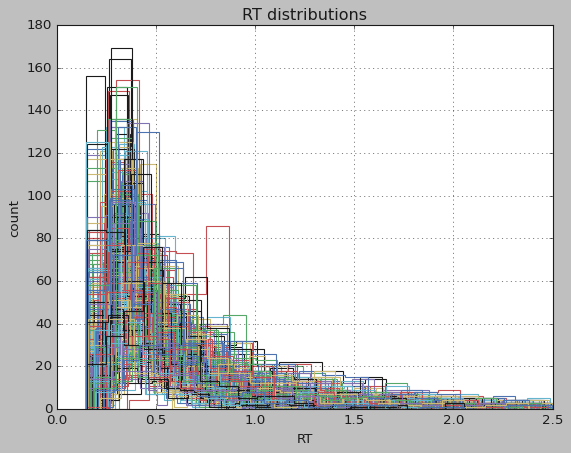

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel="RT", ylabel="count", title="RT distributions")
for i, subj_data in data.groupby("subj_idx"):
    subj_data.rt.hist(bins=20, histtype="step", ax=ax)
plt.savefig("plot_hist_rt_patients.pdf")

In [11]:
data = pd.DataFrame(data)
type(data)

pandas.core.frame.DataFrame

In [12]:
data["diag_cat"] = pd.Categorical(data["diag_cat"])
print(data["diag_cat"])

0        AN
1        AN
2        AN
3        AN
4        AN
         ..
88795    HC
88796    HC
88797    HC
88798    HC
88799    HC
Name: diag_cat, Length: 88800, dtype: category
Categories (6, object): ['AN', 'AN_R', 'BN', 'BN_R', 'HC', 'RI']


In [13]:
dicat_mapping = {'AN': "AN", "AN_R": "RI", "BN": "BN", "BN_R": "RI", "HC": "HC", "RI": "RI"}
data = data.assign(diag_cat = data["diag_cat"].map(dicat_mapping))
print(data["diag_cat"])

0        AN
1        AN
2        AN
3        AN
4        AN
         ..
88795    HC
88796    HC
88797    HC
88798    HC
88799    HC
Name: diag_cat, Length: 88800, dtype: object


In [14]:
data.groupby(["diag_cat", "stim"]).agg({"feedback": "mean"})

feedback
diag_cat stim             
AN       food     0.531964
         neutral  0.549816
BN       food     0.537500
         neutral  0.541250
HC       food     0.544912
         neutral  0.545403
RI       food     0.538750
         neutral  0.552951

In [15]:
data.groupby(["diag_cat", "stim"]).agg({"rt": "mean"})

rt
diag_cat stim             
AN       food     0.668403
         neutral  0.579149
BN       food     0.680351
         neutral  0.531536
HC       food     0.593784
         neutral  0.555062
RI       food     0.633244
         neutral  0.545061

In [16]:
df = data[data.diag_cat == "AN"]
df.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,11040.000000,11040.000000,11040.000000,11040.000000,11040.000000,11040.000000,11040.0
mean,38.347826,0.468931,0.624422,80.500000,0.492754,0.540761,0.5
std,45.897305,0.499056,0.403193,46.189211,0.499970,0.498358,0.0
min,1.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,18.000000,0.000000,0.347000,40.750000,0.000000,0.000000,0.5
50%,31.000000,0.000000,0.501000,80.500000,0.000000,1.000000,0.5
75%,47.000000,1.000000,0.773000,120.250000,1.000000,1.000000,0.5
max,286.000000,1.000000,2.488000,160.000000,1.000000,1.000000,0.5


In [17]:
df1 = data[data.diag_cat == "HC"]
df1.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,62080.000000,62080.000000,62080.000000,62080.000000,62080.000000,62080.000000,62080.0
mean,181.489691,0.476466,0.574922,80.500000,0.487113,0.545151,0.5
std,67.575569,0.499450,0.381032,46.187491,0.499838,0.497961,0.0
min,62.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,124.750000,0.000000,0.331000,40.750000,0.000000,0.000000,0.5
50%,183.000000,0.000000,0.447000,80.500000,0.000000,1.000000,0.5
75%,240.000000,1.000000,0.678000,120.250000,1.000000,1.000000,0.5
max,302.000000,1.000000,2.499000,160.000000,1.000000,1.000000,0.5


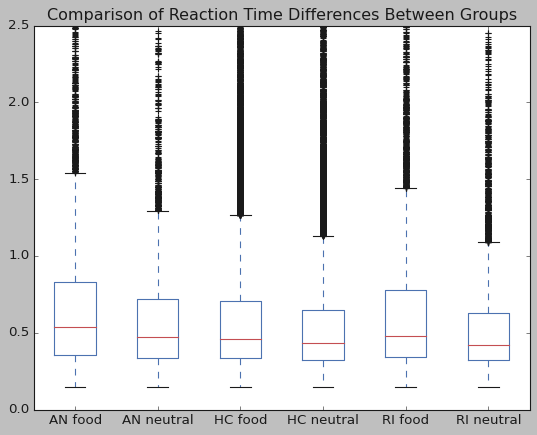

In [18]:
anf = data[(data.diag_cat == "AN") & (data.stim == "food")]
ann = data[(data.diag_cat == "AN") & (data.stim == "neutral")]
hcf = data[(data.diag_cat == "HC") & (data.stim == "food")]
hcn = data[(data.diag_cat == "HC") & (data.stim == "neutral")]
rif = data[(data.diag_cat == "RI") & (data.stim == "food")]
rin = data[(data.diag_cat == "RI") & (data.stim == "neutral")]

plt.boxplot(
    [anf.rt.values, ann.rt.values, hcf.rt.values, hcn.rt.values, rif.rt.values, rin.rt.values],
    labels=("AN food", "AN neutral", "HC food", "HC neutral", "RI food", "RI neutral"),
)
plt.title("Comparison of Reaction Time Differences Between Groups")
plt.show()

In [19]:
data.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
0,1,0,food,0.979,1,0,0,AN,ca_po_2002_05_25_700_f,0.5
1,1,0,neutral,1.553,1,1,0,AN,ca_po_2002_05_25_700_f,0.5
2,1,1,food,1.939,2,0,0,AN,ca_po_2002_05_25_700_f,0.5
3,1,1,neutral,0.350,2,1,1,AN,ca_po_2002_05_25_700_f,0.5
4,1,0,food,0.768,3,0,0,AN,ca_po_2002_05_25_700_f,0.5


In [20]:
#####
# RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time
# alpha = learning rate from negative feedbacks
# pos_alpha = learning rate from positive feedbacks

mod1 = hddm.HDDMrl(
    data,
    # bias=True,
    depends_on={
        "a": ["diag_cat", "stim"],
        "v": ["diag_cat", "stim"],
        "t": ["diag_cat", "stim"],
        "alpha": ["diag_cat", "stim"],
        "pos_alpha": ["diag_cat", "stim"],
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True,  # informative priors on ddm params
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [21]:
mod1.find_starting_values()

/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [22]:
mod1.sample(
    13000,
    burn=3000,
    dbname="ddm/ddm.db",
    db="pickle",
)

 [--                6%                  ] 843 of 13000 complete in 1635.6 sec

In [28]:
# get model traces 
grptrcs=mod1.get_group_traces() # traces of all stochastic group nodes
alltrcs=mod1.get_traces() # traces of all stochastic nodes

In [29]:
# Export traces to .csv files (for later use in R)
# Saved in directory ddm, then moved by hand to saved_fits directory.
# grptrcs.to_csv('ddm/ddm_grptrcs.csv')
# alltrcs.to_csv('ddm/ddm_alltrcs.csv')


In [30]:
print("mod1 DIC: %f" % mod1.dic)

mod1 DIC: 89842.605131


Done saving traces (202206180603)

In [33]:
# get the individual node
subj_data = mod1.get_subj_nodes()
# subj_data.head()


In [34]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n = mod1.nodes_db.node[
    ["alpha(AN.food)", "alpha(AN.neutral)", "alpha(HC.food)", "alpha(HC.neutral)"]
]

In [35]:
traces = mod1.get_traces()
traces.head()


,a(AN.food),a(AN.neutral),a(AN_R.food),a(AN_R.neutral),a(BN.food),a(BN.neutral),a(BN_R.food),a(BN_R.neutral),a(HC.food),a(HC.neutral),...,pos_alpha_subj(RI.neutral).169,pos_alpha_subj(RI.neutral).172,pos_alpha_subj(RI.neutral).186,pos_alpha_subj(RI.neutral).202,pos_alpha_subj(RI.neutral).204,pos_alpha_subj(RI.neutral).217,pos_alpha_subj(RI.neutral).222,pos_alpha_subj(RI.neutral).238,pos_alpha_subj(RI.neutral).271,pos_alpha_subj(RI.neutral).278
0,1.439793,1.222435,1.296805,1.209661,1.413872,1.136512,1.316515,1.242544,1.336188,1.236986,...,1.654535,3.974973,2.145453,0.423781,2.011563,3.183256,-1.231823,-0.488127,-0.812847,3.001064
1,1.441315,1.226138,1.383564,1.258935,1.444430,1.160587,1.176407,1.385506,1.301932,1.238252,...,1.513683,3.552540,4.864381,-0.089344,3.326781,2.493049,-2.072679,-0.069987,-0.602891,2.920029
2,1.383419,1.279293,1.139655,1.294435,1.446582,1.106301,1.433596,1.187292,1.352222,1.241186,...,3.276712,2.676063,3.643091,-0.189262,1.615428,2.514921,-0.492608,-0.558405,-0.383432,2.057121
3,1.398584,1.208179,1.506808,1.320073,1.323904,1.139524,1.306751,1.035934,1.341399,1.273982,...,3.002373,5.007899,3.799154,-0.595113,2.639441,1.431473,0.187732,-0.468766,-0.276225,2.274571
4,1.378652,1.282850,1.233931,1.372114,1.451114,1.287134,1.506760,1.381307,1.335702,1.247381,...,5.582512,2.360113,4.748962,0.079155,4.628413,7.914913,0.792464,-0.534347,-0.644824,1.417597


In [36]:
# Saved and then moved by hand to saved_fits directory.
# traces.to_csv("traces.csv")

In [ ]:
# alpha_an_f.trace()


In [37]:
traces["score_diff"] = traces["a(AN.food)"] - traces["a(AN.neutral)"]

The following code creates a figure of the posterior density plot of the difference between the parameters estimated in two conditions.


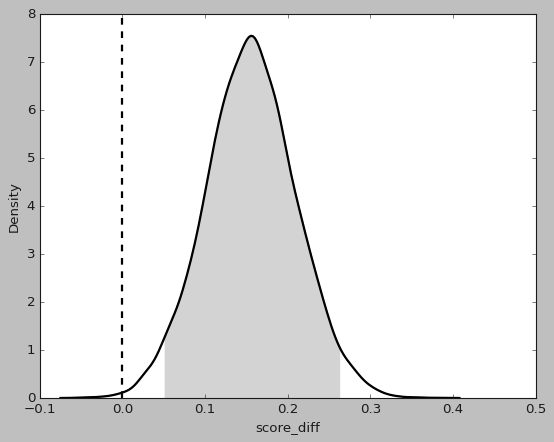

In [38]:
quantiles = traces['score_diff'].quantile([0.025, 0.975])

# Define delta lower and upper limits
low, high = quantiles[0.025], quantiles[0.975]

sns_plot = sns.kdeplot(data=traces, x="score_diff")

line = sns_plot.lines[0]
x, y = line.get_data()

plt.plot(x, y, color='black', lw=2)

idx_delta = np.logical_and(x >= low, x <= high)

plt.fill_between(x, y, where=idx_delta, color='lightgray')

plt.axvline(0, color='black', linestyle='--', linewidth=2)

sns_plot.figure.savefig("output.pdf")


In [89]:
# get model traces
grptrcs = mod1.get_group_traces()  # traces of all stochastic group nodes
alltrcs = mod1.get_traces()  # traces of all stochastic nodes


In [90]:
# export traces to .csv files (for later use in R)
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')


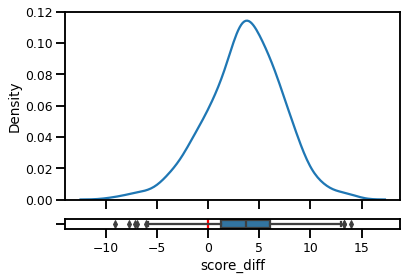

In [114]:
# # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
# f, (ax_kdeplot, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.95, .05)})

# # assigning a graph to each ax

# sns.kdeplot(data=traces, x="score_diff", ax=ax_kdeplot)
# plt.axvline(0, color='r')

# sns.boxplot(data=traces, x="score_diff", ax=ax_box)

# # Remove x axis name for the boxplot
# # ax_box.set(xlabel='')
# plt.show()

# # plt.savefig('plot_score_diff.pdf')


In [42]:
alpha_an_f,  alpha_an_n, alpha_anr_f, alpha_anr_n, alpha_bn_f,  alpha_bn_n, alpha_bnr_f, alpha_bnr_n, alpha_hc_f,  alpha_hc_n, alpha_ri_f,  alpha_ri_n = mod1.nodes_db.node[[
    'alpha(AN.food)',   'alpha(AN.neutral)',
    'alpha(AN_R.food)', 'alpha(AN_R.neutral)',
    'alpha(BN.food)',   'alpha(BN.neutral)',
    'alpha(BN_R.food)', 'alpha(BN_R.neutral)',
    'alpha(HC.food)',   'alpha(HC.neutral)',
    'alpha(RI.food)',   'alpha(RI.neutral)',
]]


In [43]:
pos_alpha_an_f,  pos_alpha_an_n, pos_alpha_anr_f, pos_alpha_anr_n, pos_alpha_bn_f,  pos_alpha_bn_n, pos_alpha_bnr_f, pos_alpha_bnr_n, pos_alpha_hc_f,  pos_alpha_hc_n, pos_alpha_ri_f,  pos_alpha_ri_n = mod1.nodes_db.node[[
    'pos_alpha(AN.food)',   'pos_alpha(AN.neutral)',
    'pos_alpha(AN_R.food)', 'pos_alpha(AN_R.neutral)',
    'pos_alpha(BN.food)',   'pos_alpha(BN.neutral)',
    'pos_alpha(BN_R.food)', 'pos_alpha(BN_R.neutral)',
    'pos_alpha(HC.food)',   'pos_alpha(HC.neutral)',
    'pos_alpha(RI.food)',   'pos_alpha(RI.neutral)',
]]


In [44]:
mod1.plot_posterior_predictive()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Alpha


Text(0.5, 1.0, 'Posterior of negative alpha group means')

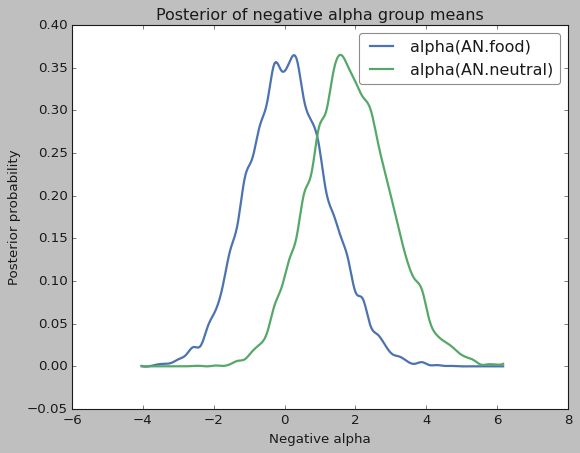

In [45]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_an_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')


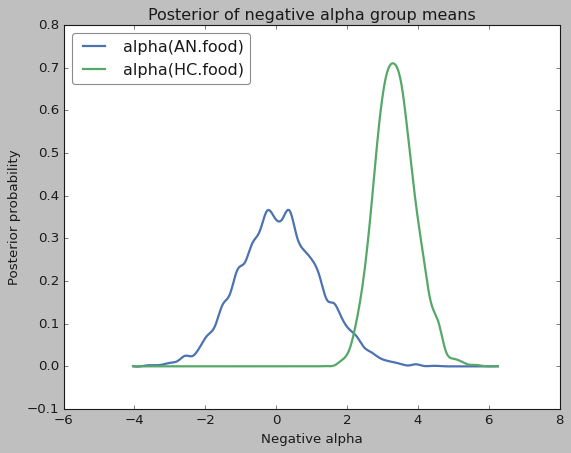

In [46]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_hc_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')
plt.savefig('negative_alpha_group_means.pdf', pad_inches=4.5)


Text(0.5, 1.0, 'Posterior of negative alpha group means')

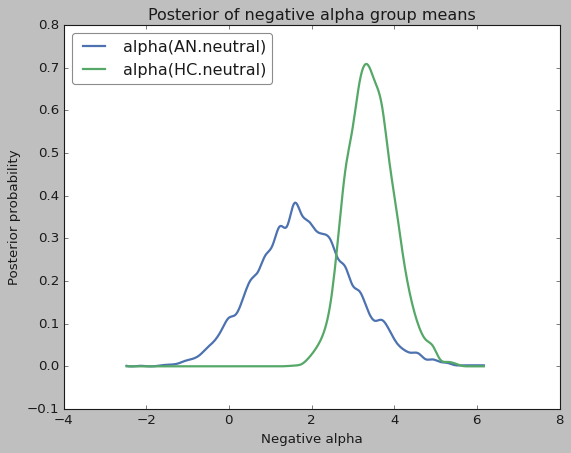

In [47]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')


Text(0.5, 1.0, 'Posterior of positive alpha group means')

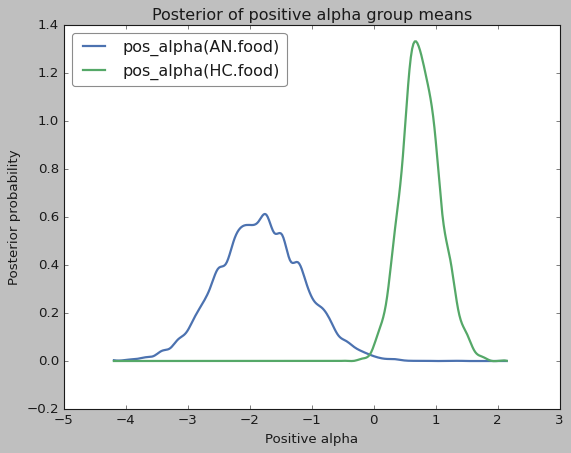

In [48]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_f, pos_alpha_hc_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')


Text(0.5, 1.0, 'Posterior of positive alpha group means')

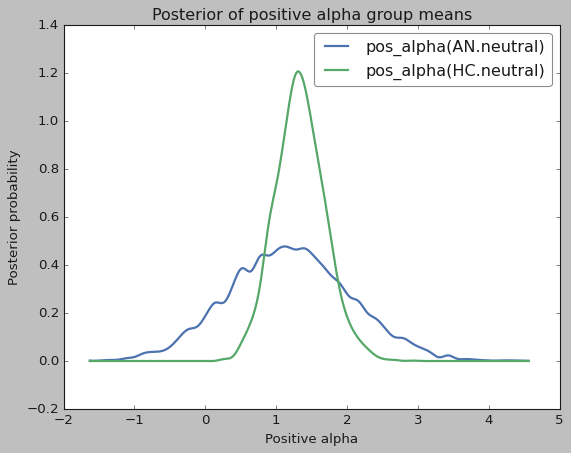

In [49]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')


In [50]:
print("P(neg-alpha AN food > neg-alpha HC food) = ",
      (alpha_an_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN neutral > neg-alpha HC neutral) = ",
      (alpha_an_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN food > pos-alpha HC food) = ",
      (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN neutral > pos-alpha HC neutral) = ",
      (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN food > neg-alpha HC food) =  0.0073
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.112
P(pos-alpha AN food > pos-alpha HC food) =  0.0003
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.4292


In [51]:
print("P(neg-alpha AN-R food > neg-alpha HC food) = ",
      (alpha_anr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN-R neutral > neg-alpha HC neutral) = ",
      (alpha_anr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN-R food > pos-alpha HC food) = ",
      (pos_alpha_anr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN-R neutral > pos-alpha HC neutral) = ",
      (pos_alpha_anr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN-R food > neg-alpha HC food) =  0.362
P(neg-alpha AN-R neutral > neg-alpha HC neutral) =  0.3236
P(pos-alpha AN-R food > pos-alpha HC food) =  0.5352
P(pos-alpha AN-R neutral > pos-alpha HC neutral) =  0.259


In [52]:
print("P(neg-alpha BN food > neg-alpha HC food) = ",
      (alpha_bn_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN neutral > neg-alpha HC neutral) = ",
      (alpha_bn_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN food > pos-alpha HC food) = ",
      (pos_alpha_bn_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN neutral > pos-alpha HC neutral) = ",
      (pos_alpha_bn_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN food > neg-alpha HC food) =  0.0675
P(neg-alpha BN neutral > neg-alpha HC neutral) =  0.1582
P(pos-alpha BN food > pos-alpha HC food) =  0.3888
P(pos-alpha BN neutral > pos-alpha HC neutral) =  0.3821


In [53]:
print("P(neg-alpha BN-R food > neg-alpha HC food) = ",
      (alpha_bnr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN-R neutral > neg-alpha HC neutral) = ",
      (alpha_bnr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN-R food > pos-alpha HC food) = ",
      (pos_alpha_bnr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN-R neutral > pos-alpha HC neutral) = ",
      (pos_alpha_bnr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN-R food > neg-alpha HC food) =  0.3942
P(neg-alpha BN-R neutral > neg-alpha HC neutral) =  0.3401
P(pos-alpha BN-R food > pos-alpha HC food) =  0.6585
P(pos-alpha BN-R neutral > pos-alpha HC neutral) =  0.3457


In [54]:
print("P(neg-alpha RI food > neg-alpha HC food) = ",
      (alpha_ri_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha RI neutral > neg-alpha HC neutral) = ",
      (alpha_ri_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha RI food > pos-alpha HC food) = ",
      (pos_alpha_ri_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha RI neutral > pos-alpha HC neutral) = ",
      (pos_alpha_ri_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha RI food > neg-alpha HC food) =  0.252
P(neg-alpha RI neutral > neg-alpha HC neutral) =  0.0786
P(pos-alpha RI food > pos-alpha HC food) =  0.4909
P(pos-alpha RI neutral > pos-alpha HC neutral) =  0.5893


# Drift rate


In [51]:
v_an_f,  v_an_n, v_anr_f, v_anr_n, v_bn_f,  v_bn_n, v_bnr_f, v_bnr_n, v_hc_f,  v_hc_n, v_ri_f,  v_ri_n = mod1.nodes_db.node[[
    'v(AN.food)',   'v(AN.neutral)',
    'v(AN_R.food)', 'v(AN_R.neutral)',
    'v(BN.food)',   'v(BN.neutral)',
    'v(BN_R.food)', 'v(BN_R.neutral)',
    'v(HC.food)',   'v(HC.neutral)',
    'v(RI.food)',   'v(RI.neutral)',
]]


In [52]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ",
      (v_an_n.trace() > v_hc_n.trace()).mean())
print("P(v AN-R food > v HC food) = ",
      (v_anr_f.trace() > v_hc_f.trace()).mean())
print("P(v AN-R neutral > v HC neutral) = ",
      (v_anr_n.trace() > v_hc_n.trace()).mean())


P(v AN food > v HC food) =  0.5046
P(v AN neutral > v HC neutral) =  0.0498
P(v AN-R food > v HC food) =  0.302
P(v AN-R neutral > v HC neutral) =  0.6681


In [53]:
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ",
      (v_bn_n.trace() > v_hc_n.trace()).mean())
print("P(v BN-R food > v HC food) = ",
      (v_bnr_f.trace() > v_hc_f.trace()).mean())
print("P(v BN-R neutral > v HC neutral) = ",
      (v_bnr_n.trace() > v_hc_n.trace()).mean())


P(v BN food > v HC food) =  0.2981
P(v BN neutral > v HC neutral) =  0.904
P(v BN-R food > v HC food) =  0.3431
P(v BN-R neutral > v HC neutral) =  0.504


In [54]:
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ",
      (v_ri_n.trace() > v_hc_n.trace()).mean())


P(v RI food > v HC food) =  0.2634
P(v RI neutral > v HC neutral) =  0.8242


In [55]:
print("P(v AN food < v AN neutral) = ", (v_an_f.trace() < v_an_n.trace()).mean())
print("P(v BN food < v BN neutral) = ", (v_bn_f.trace() < v_bn_n.trace()).mean())
print("P(v HC food < v HC neutral) = ", (v_hc_f.trace() < v_hc_n.trace()).mean())
print("P(v RI food < v RI neutral) = ", (v_ri_f.trace() < v_ri_n.trace()).mean())
print("P(v BN-R food < v BN-R neutral) = ", (v_bnr_f.trace() < v_bnr_n.trace()).mean())
print("P(v AN-R food < v AN-R neutral) = ", (v_anr_f.trace() < v_anr_n.trace()).mean())

P(v AN food < v AN neutral) =  0.1009
P(v BN food < v BN neutral) =  0.9007
P(v HC food < v HC neutral) =  0.432
P(v RI food < v RI neutral) =  0.8753
P(v BN-R food < v BN-R neutral) =  0.5986
P(v AN-R food < v AN-R neutral) =  0.7391


# Decision threshold


In [42]:
a_an_f,  a_an_n, a_anr_f, a_anr_n, a_bn_f,  a_bn_n, a_bnr_f, a_bnr_n, a_hc_f,  a_hc_n, a_ri_f,  a_ri_n = mod1.nodes_db.node[[
    'a(AN.food)',   'a(AN.neutral)',
    'a(AN_R.food)', 'a(AN_R.neutral)',
    'a(BN.food)',   'a(BN.neutral)',
    'a(BN_R.food)', 'a(BN_R.neutral)',
    'a(HC.food)',   'a(HC.neutral)',
    'a(RI.food)',   'a(RI.neutral)',
]]


In [43]:
print("P(a AN food < a HC food) = ", (a_an_f.trace() < a_hc_f.trace()).mean())
print("P(a AN neutral < a HC neutral) = ",
      (a_an_n.trace() < a_hc_n.trace()).mean())
print("P(a AN-R food < a HC food) = ",
      (a_anr_f.trace() < a_hc_f.trace()).mean())
print("P(a AN-R neutral < a HC neutral) = ",
      (a_anr_n.trace() < a_hc_n.trace()).mean())


P(a AN food < a HC food) =  0.041
P(a AN neutral < a HC neutral) =  0.4701
P(a AN-R food < a HC food) =  0.4864
P(a AN-R neutral < a HC neutral) =  0.2377


In [44]:
print("P(a BN food < a HC food) = ", (a_bn_f.trace() < a_hc_f.trace()).mean())
print("P(a BN neutral < a HC neutral) = ", (a_bn_n.trace() < a_hc_n.trace()).mean())
print("P(a BN-R food < a HC food) = ", (a_bnr_f.trace() < a_hc_f.trace()).mean())
print("P(a BN-R neutral < a HC neutral) = ", (a_bnr_n.trace() < a_hc_n.trace()).mean())

P(a BN food < a HC food) =  0.0779
P(a BN neutral < a HC neutral) =  0.6423
P(a BN-R food < a HC food) =  0.3939
P(a BN-R neutral < a HC neutral) =  0.3878


In [45]:
print("P(a RI food < a HC food) = ", (a_ri_f.trace() < a_hc_f.trace()).mean())
print("P(a RI neutral < a HC neutral) = ", (a_ri_n.trace() < a_hc_n.trace()).mean())

P(a RI food < a HC food) =  0.6149
P(a RI neutral < a HC neutral) =  0.6776


In [50]:
print("P(a AN food < a AN neutral) = ", (a_an_f.trace() < a_an_n.trace()).mean())
print("P(a BN food < a BN neutral) = ", (a_bn_f.trace() < a_bn_n.trace()).mean())
print("P(a HC food < a HC neutral) = ", (a_hc_f.trace() < a_hc_n.trace()).mean())
print("P(a RI food < a RI neutral) = ", (a_ri_f.trace() < a_ri_n.trace()).mean())

print("P(a BN-R food < a BN-R neutral) = ", (a_bnr_f.trace() < a_bnr_n.trace()).mean())
print("P(a AN-R food < a AN-R neutral) = ", (a_anr_f.trace() < a_anr_n.trace()).mean())

P(a AN food < a AN neutral) =  0.0018
P(a BN food < a BN neutral) =  0.0176
P(a HC food < a HC neutral) =  0.0
P(a RI food < a RI neutral) =  0.0836
P(a BN-R food < a BN-R neutral) =  0.2835
P(a AN-R food < a AN-R neutral) =  0.3853


# Non decision time


In [57]:
(
    t_an_f,
    t_an_n,
    t_anr_f,
    t_anr_n,
    t_bn_f,
    t_bn_n,
    t_bnr_f,
    t_bnr_n,
    t_hc_f,
    t_hc_n,
    t_ri_f,
    t_ri_n,
) = mod1.nodes_db.node[
    [
        "t(AN.food)",
        "t(AN.neutral)",
        "t(AN_R.food)",
        "t(AN_R.neutral)",
        "t(BN.food)",
        "t(BN.neutral)",
        "t(BN_R.food)",
        "t(BN_R.neutral)",
        "t(HC.food)",
        "t(HC.neutral)",
        "t(RI.food)",
        "t(RI.neutral)",
    ]
]

In [58]:
print("P(t AN food < t HC food) = ", (t_an_f.trace() < t_hc_f.trace()).mean())
print("P(t AN neutral < t HC neutral) = ", (t_an_n.trace() < t_hc_n.trace()).mean())
print("P(t AN-R food < t HC food) = ", (t_anr_f.trace() < t_hc_f.trace()).mean())
print("P(t AN-R neutral < t HC neutral) = ", (t_anr_n.trace() < t_hc_n.trace()).mean())

P(t AN food < t HC food) =  0.4703
P(t AN neutral < t HC neutral) =  0.2998
P(t AN-R food < t HC food) =  0.0972
P(t AN-R neutral < t HC neutral) =  0.4838


In [59]:
print("P(t BN food < t HC food) = ", (t_bn_f.trace() < t_hc_f.trace()).mean())
print("P(t BN neutral < t HC neutral) = ", (t_bn_n.trace() < t_hc_n.trace()).mean())
print("P(t BN-R food < t HC food) = ", (t_bnr_f.trace() < t_hc_f.trace()).mean())
print("P(t BN-R neutral < t HC neutral) = ", (t_bnr_n.trace() < t_hc_n.trace()).mean())

P(t BN food < t HC food) =  0.6766
P(t BN neutral < t HC neutral) =  0.4687
P(t BN-R food < t HC food) =  0.2704
P(t BN-R neutral < t HC neutral) =  0.2958


In [60]:
print("P(t RI food < t HC food) = ", (t_ri_f.trace() < t_hc_f.trace()).mean())
print("P(t RI neutral < t HC neutral) = ", (t_ri_n.trace() < t_hc_n.trace()).mean())

P(t RI food < t HC food) =  0.3892
P(t RI neutral < t HC neutral) =  0.5087


In [61]:
print("P(t AN food < t AN neutral) = ", (t_an_f.trace() < t_an_n.trace()).mean())
print("P(t BN food < t BN neutral) = ", (t_bn_f.trace() < t_bn_n.trace()).mean())
print("P(t HC food < t HC neutral) = ", (t_hc_f.trace() < t_hc_n.trace()).mean())
print("P(t RI food < t RI neutral) = ", (t_ri_f.trace() < t_ri_n.trace()).mean())
print("P(t BN-R food < t BN-R neutral) = ", (t_bnr_f.trace() < t_bnr_n.trace()).mean())
print("P(t AN-R food < t AN-R neutral) = ", (t_anr_f.trace() < t_anr_n.trace()).mean())

P(t AN food < t AN neutral) =  0.8327
P(t BN food < t BN neutral) =  0.7763
P(t HC food < t HC neutral) =  0.9375
P(t RI food < t RI neutral) =  0.633
P(t BN-R food < t BN-R neutral) =  0.5846
P(t AN-R food < t AN-R neutral) =  0.245


# Print fitted parameters and other model statistics


In [116]:
mod1.print_stats()


                                    mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(AN.food)                      1.367597  0.081064  1.263211  1.272168  1.381836  1.446393  1.485142  0.025635
a(AN.neutral)                   1.207505  0.036535  1.141996  1.189012  1.215912  1.228924  1.282121  0.011553
a(BN.food)                      1.410352  0.041808  1.334177  1.379947    1.4084  1.451177  1.474424  0.013221
a(BN.neutral)                   1.182662  0.040372  1.120391  1.155089  1.187337  1.212555  1.249879  0.012767
a(HC.food)                      1.322142  0.020325  1.295701  1.300469  1.330053  1.339239  1.357984  0.006427
a(HC.neutral)                   1.242582  0.012131  1.218673  1.233804  1.244827  1.248535  1.265126  0.003836
a(RI.food)                      1.312418  0.031733  1.261475  1.279049  1.329661  1.339863  1.354167  0.010035
a(RI.neutral)                   1.244828  0.028559  1.201975  1.230559  1.236796   1.26177  1.312898  0.009031
a

## Checking results


In [ ]:
mod1.plot_posteriors()


### Estimate convergence


In [21]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        data,
        # bias=True,
        depends_on={
            'a': ['diag_cat', 'stim'],
            'v': ['diag_cat', 'stim'],
            't': ['diag_cat', 'stim'],
            'alpha': ['diag_cat', 'stim'],
            'pos_alpha': ['diag_cat', 'stim']
        },
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True
    )
    m.sample(1500, burn=500, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 3326.8 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 3345.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 3304.8 sec

In [22]:
gel_rub = gelman_rubin(models)
str(gel_rub)

"{'a(AN.food)': 0.999660794786233, 'a(AN.neutral)': 0.9995872842343416, 'a(AN_R.food)': 1.0017754461803174, 'a(AN_R.neutral)': 1.0008705536011613, 'a(BN.food)': 1.0019401200092943, 'a(BN.neutral)': 1.0004257242329653, 'a(BN_R.food)': 1.0009399092142501, 'a(BN_R.neutral)': 1.002049243928591, 'a(HC.food)': 1.000412858127868, 'a(HC.neutral)': 0.9998525665312364, 'a(RI.food)': 0.9999823494962898, 'a(RI.neutral)': 1.0005676958921998, 'a_std': 1.0005542201135467, 'a_subj(AN.food).1': 0.9995631520306192, 'a_subj(AN.food).6': 1.0040901439925844, 'a_subj(AN.food).7': 0.999672702040121, 'a_subj(AN.food).9': 0.9995023127892654, 'a_subj(AN.food).10': 0.9999541047735875, 'a_subj(AN.food).11': 1.0033796615067543, 'a_subj(AN.food).12': 1.0006720650623901, 'a_subj(AN.food).13': 1.000394176392688, 'a_subj(AN.food).18': 1.0011686584026507, 'a_subj(AN.food).19': 0.9999450630356429, 'a_subj(AN.food).20': 1.0007504601221322, 'a_subj(AN.food).23': 1.005496875936693, 'a_subj(AN.food).24': 1.0015359015399272,

In [23]:
np.max(list(gelman_rubin(models).values()))


1.0757867285905993

In [24]:
np.mean(list(gelman_rubin(models).values()))


1.0020651472099595

In [25]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)


Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what’s usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. Daw, 2011).


In [26]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n, pos_alpha_an_f, pos_alpha_an_n, pos_alpha_hc_f, pos_alpha_hc_n, t_an_f, t_an_n, t_hc_f, t_hc_n, a_an_f, a_an_n, a_hc_f, a_hc_n, v_an_f, v_an_n, v_hc_f, v_hc_n = m.nodes_db.node[[
    'alpha(AN.food)', 'alpha(AN.neutral)', 'alpha(HC.food)', 'alpha(HC.neutral)',
    'pos_alpha(AN.food)', 'pos_alpha(AN.neutral)', 'pos_alpha(HC.food)', 'pos_alpha(HC.neutral)',
    't(AN.food)', 't(AN.neutral)', 't(HC.food)', 't(HC.neutral)',
    'a(AN.food)', 'a(AN.neutral)', 'a(HC.food)', 'a(HC.neutral)',
    'v(AN.food)', 'v(AN.neutral)', 'v(HC.food)', 'v(HC.neutral)'
]]


In [27]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'alpha(HC.food)': alpha_hc_f.trace(),
    'alpha(HC.neutral)': alpha_hc_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    'pos_alpha(HC.food)': pos_alpha_hc_f.trace(),
    'pos_alpha(HC.neutral)': pos_alpha_hc_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    't(HC.food)': t_hc_f.trace(),
    't(HC.neutral)': t_hc_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'a(HC.food)': a_hc_f.trace(),
    'a(HC.neutral)': a_hc_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace(),
    'v(HC.food)': v_hc_f.trace(),
    'v(HC.neutral)': v_hc_n.trace()
}


In [28]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace()
}


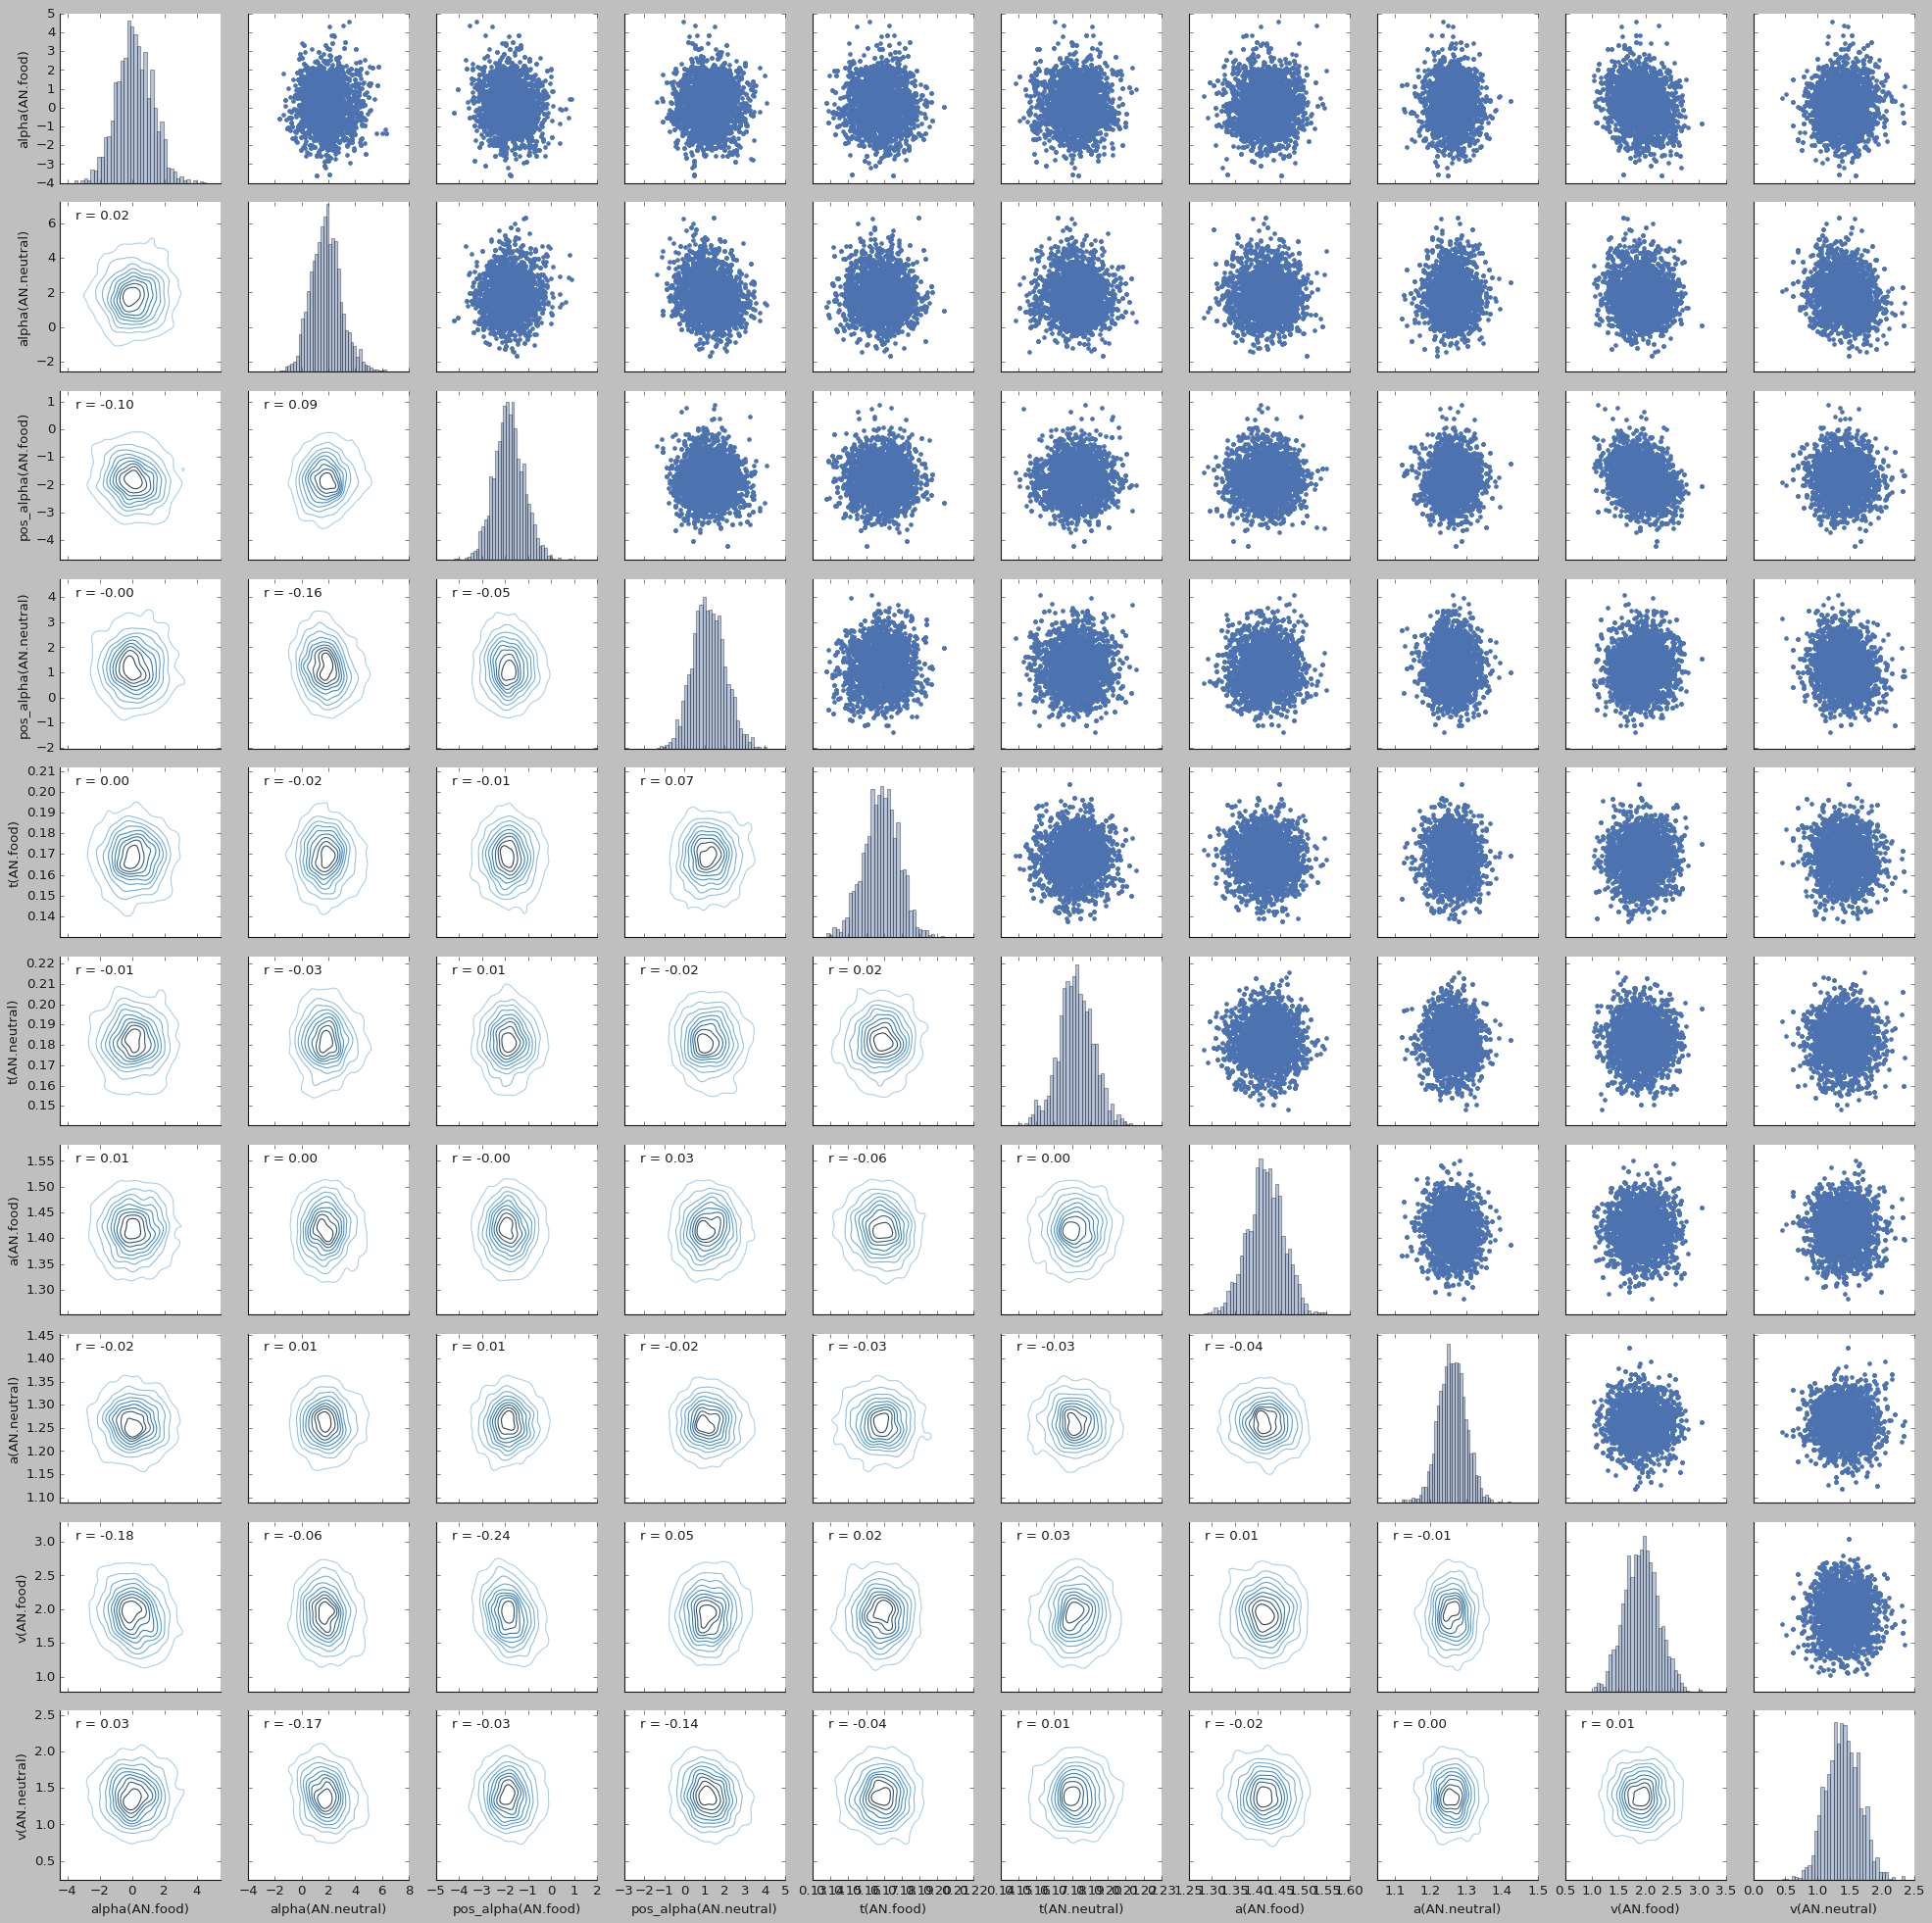

In [29]:
samp = pd.DataFrame(data=samples)


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')


## Posterior predictive checks


An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).


#### AN food


In [219]:
data = data[
    (data.subj_code == "am_gu_1999_02_11_937_f") |  # AN
    (data.subj_code == "an_de_1998_11_10_289_f") |  # AN
    (data.subj_code == "gi_lo_2001_06_20_106_f") |  # HC
    (data.subj_code == "bi_ra_2000_09_28_341_f")   # HC
]

d = data[(data.diag_cat == "AN")]
d.shape


(640, 10)

In [234]:
d = data

In [220]:
# Change subj_idx
d.loc[d.subj_code == "am_gu_1999_02_11_937_f", "subj_idx"] = 0
d.loc[d.subj_code == "an_de_1998_11_10_289_f", "subj_idx"] = 1

d.tail()


,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
11195,1,1,neutral,0.527,158,1,1,AN,an_de_1998_11_10_289_f,0.5
11196,1,0,food,0.488,159,0,0,AN,an_de_1998_11_10_289_f,0.5
11197,1,1,neutral,0.323,159,1,1,AN,an_de_1998_11_10_289_f,0.5
11198,1,1,food,0.499,160,0,1,AN,an_de_1998_11_10_289_f,0.5
11199,1,1,neutral,0.402,160,1,1,AN,an_de_1998_11_10_289_f,0.5


In [236]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        d,
        # bias=True,
        p_outlier=0.05
    )
    m.sample(600, burn=100, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 727.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 766.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 780.3 sec

In [52]:
# Combine the models
# m = kabuki.utils.concat_models(models)
traces = m.get_traces()
traces.head()


,a(AN.food),a(AN.neutral),a(AN_R.food),a(AN_R.neutral),a(BN.food),a(BN.neutral),a(BN_R.food),a(BN_R.neutral),a(HC.food),a(HC.neutral),...,pos_alpha_subj(RI.neutral).175,pos_alpha_subj(RI.neutral).178,pos_alpha_subj(RI.neutral).192,pos_alpha_subj(RI.neutral).208,pos_alpha_subj(RI.neutral).210,pos_alpha_subj(RI.neutral).223,pos_alpha_subj(RI.neutral).228,pos_alpha_subj(RI.neutral).244,pos_alpha_subj(RI.neutral).279,pos_alpha_subj(RI.neutral).286
0,1.419147,1.302546,1.175882,1.363120,1.384228,1.084609,1.323063,1.427180,1.344488,1.280353,...,0.295609,0.139912,0.108769,0.104712,0.084675,0.129573,0.176320,0.245254,0.161436,0.178513
1,1.345688,1.211257,1.267658,1.351603,1.432092,1.083462,1.346401,1.444872,1.315966,1.268457,...,0.155061,0.134077,0.074951,0.307244,0.070489,0.153472,0.206688,0.154490,0.306958,0.224305
2,1.427129,1.322904,1.407411,1.408192,1.523244,1.243772,1.409840,1.140137,1.350847,1.252018,...,0.338768,0.265431,0.093580,0.066371,0.106976,0.295046,0.208696,0.124594,0.095323,0.224523
3,1.356022,1.350327,1.267006,1.231057,1.391070,1.215077,1.318142,1.422669,1.340157,1.244962,...,0.035280,0.181331,0.102702,0.304889,0.108507,0.216067,0.265623,0.218978,0.103937,0.078373
4,1.338982,1.316591,1.435211,1.250458,1.326826,1.243233,1.391460,1.181983,1.331754,1.260010,...,0.263810,0.173877,0.242322,0.299826,0.137289,0.217771,0.126325,0.057155,0.128853,0.109847


Now that we have the traces the next step is to simulate data using the estimated parameters.

Inputs to function:

- a = decision threshold
- t = non-decision time
- alpha = learning rate pos*alpha = defaults to 0 -- if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate* for negative prediction errors.
- scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0
- p_lower = the probability of reward for the option represented by the lower boundary.
- subjs = number of subjects to simulate data for.
- split_by = define the condition which makes it easier to append data from different conditions.
- size = number of trials per subject.


In [238]:
df = hddm.generate.gen_rand_rlddm_data(
    a=1.4,
    t=0.3,
    alpha=0.5,
    scaler=2,
    p_upper=0.7,
    p_lower=0.3,
    subjs=2,
    split_by=0,
    size=10
)


In [239]:
print(df)


       q_up     q_low  sim_drift  response        rt  feedback  subj_idx  \
0  0.500000  0.500000   0.000000       0.0  0.942301       0.0         0   
1  0.500000  0.253681   0.385249       1.0  0.482301       1.0         0   
2  0.746319  0.253681   0.770498       1.0  0.715301       1.0         0   
3  0.871292  0.253681   0.965959       1.0  0.421301       1.0         0   
4  0.934698  0.253681   1.065128       1.0  1.078301       1.0         0   
5  0.966868  0.253681   1.115443       1.0  0.441301       0.0         0   
6  0.490552  0.253681   0.370473       1.0  0.509301       1.0         0   
7  0.741526  0.253681   0.763001       1.0  1.793301       0.0         0   
8  0.376222  0.253681   0.191657       1.0  0.497301       1.0         0   
9  0.683519  0.253681   0.672277       0.0  0.796301       0.0         0   
0  0.500000  0.500000   0.000000       1.0  0.538185       1.0         1   
1  0.709846  0.500000   0.318455       0.0  0.884185       0.0         1   
2  0.709846 

In [240]:
from tqdm import tqdm  # progress tracker
# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
d['samp'] = 0
# load traces
traces = m.get_traces()


In [242]:
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 10)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0]-1)
    # loop through all subjects in observed data
    for s in d.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 0)].trial.unique())
        size1 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 1)].trial.unique())
        # size2 = len(d[(d['subj_idx']==s) & (d['split_by']==2)].trial.unique())
        # set parameter values for simulation
        a = traces.loc[sample, 'a_subj.'+str(s)]
        t = traces.loc[sample, 't_subj.'+str(s)]
        scaler = traces.loc[sample, 'v_subj.'+str(s)]
        alphaInv = traces.loc[sample, 'alpha_subj.'+str(s)]
        # #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        # #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size0, p_upper=0.7, p_lower=0.3, split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size1, p_upper=0.7, p_lower=0.3, split_by=1)
        # #sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        # #append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # #assign subj_idx
        sim_data0['subj_idx'] = s
        # #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        # #identify the simulated data
        sim_data0['samp'] = i
        # #append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)


  0%|          | 0/9 [00:21<?, ?it/s]


KeyError: 0

In [227]:
# combine observed and simulated data
ppc_data = d[['subj_idx', 'response', 'split_by',
              'rt', 'trial', 'feedback', 'samp']].copy()
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx', 'response', 'split_by',
                      'rt', 'trial', 'feedback', 'type', 'samp']].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv('ppc_data_tutorial.csv')


In [228]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()

In [229]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data['bin_trial'] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)).astype('int64')
# calculate means for each sample
sums = plot_ppc_data.groupby(
    ['bin_trial', 'split_by', 'samp', 'type']).mean().reset_index()
# calculate the overall mean response across samples
ppc_sim = sums.groupby(['bin_trial', 'split_by', 'type']).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim['upper_hpd'] = 0
ppc_sim['lower_hpd'] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial'] == ppc_sim.bin_trial[i]) & (
        sums['split_by'] == ppc_sim.split_by[i]) & (sums['type'] == ppc_sim.type[i])], alpha=0.1)
    ppc_sim.loc[i, 'upper_hpd'] = hdi[1]
    ppc_sim.loc[i, 'lower_hpd'] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim['up_err'] = ppc_sim['upper_hpd']-ppc_sim['response']
ppc_sim['low_err'] = ppc_sim['response']-ppc_sim['lower_hpd']
ppc_sim['model'] = 'RLDDM_single_learning'
ppc_sim.to_csv('ppc_choicedata_tutorial.csv')


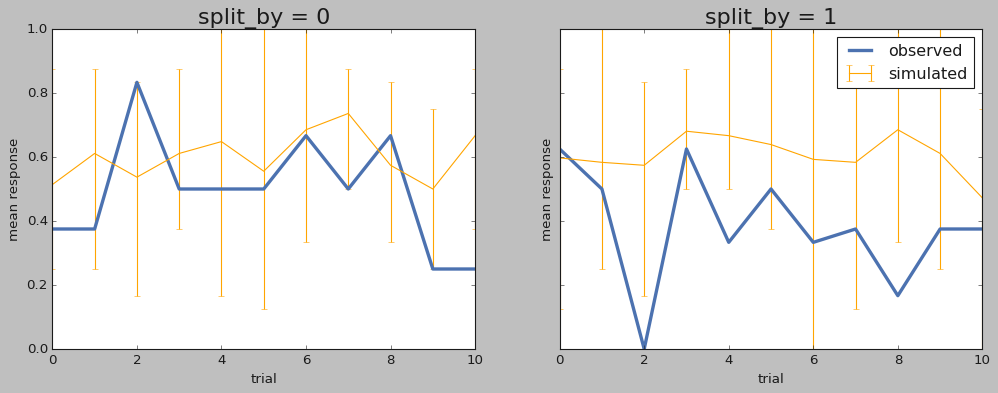

In [230]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1,
                        ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[
                d.low_err, d.up_err], label='simulated', color='orange')
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'observed')]
    ax.plot(d.bin_trial, d.response, linewidth=3, label='observed')
    ax.set_title('split_by = %i' % i, fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()
fig.savefig('PPCchoice.pdf')


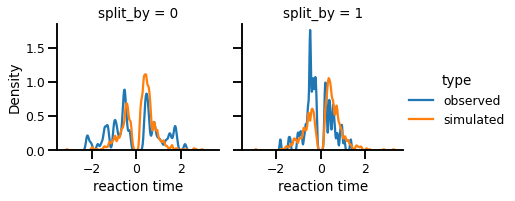

In [208]:
# set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data['reaction time'] = np.where(
    plot_ppc_data['response'] == 1, plot_ppc_data.rt, 0-plot_ppc_data.rt)
# plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy.
g = sns.FacetGrid(plot_ppc_data, col='split_by', hue='type')
g.map(sns.kdeplot, 'reaction time', bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig('PPCrt_dist.pdf')


## Parameter recovery


In [21]:
param_recovery = hddm.load_csv('recovery_sim_est_rlddm.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'recovery_sim_est_rlddm.csv'